# Advanced Mushroom Classification

This notebook explores multiple machine learning models to improve the accuracy of the mushroom classifier.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Configure plots
plt.style.use('ggplot')
sns.set_theme()
%matplotlib inline

## 1. Data Loading and Exploration

In [2]:
# Load data
df = pd.read_csv('../data/secondary_data.csv', delimiter=';')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [3]:
# Basic info
print("Dataset info:")
df.info()

# Class distribution
class_counts = df['class'].value_counts()
print("\nClass distribution:")
print(class_counts)
print(f"Percentage of edible mushrooms: {class_counts.get('e', 0)/len(df)*100:.2f}%")
print(f"Percentage of poisonous mushrooms: {class_counts.get('p', 0)/len(df)*100:.2f}%")

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-

C:\Users\vatsa\AppData\Local\Temp\ipykernel_27880\3738644369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class', data=df, palette=['#4CAF50', '#F44336'])


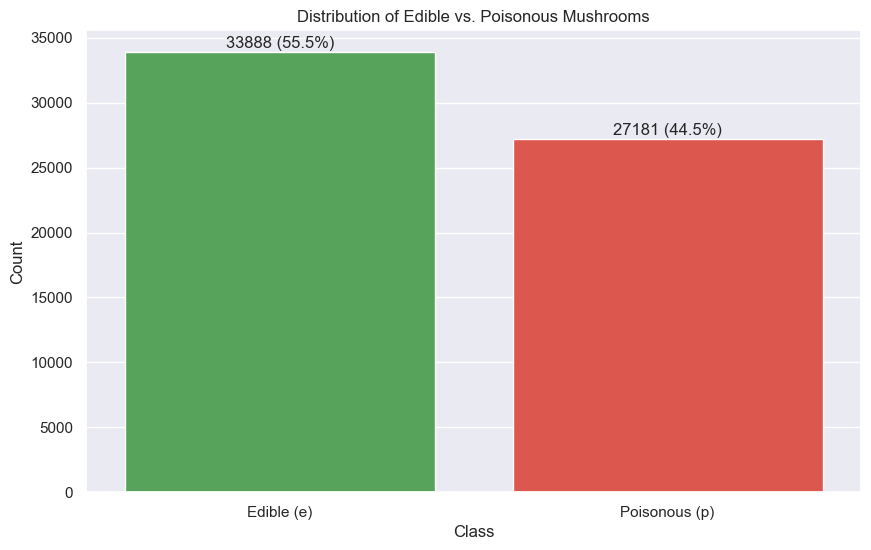

In [4]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='class', data=df, palette=['#4CAF50', '#F44336'])
plt.title('Distribution of Edible vs. Poisonous Mushrooms')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Edible (e)', 'Poisonous (p)'])

# Add count labels
for i, count in enumerate(class_counts):
    ax.text(i, count + 100, f"{count} ({count/len(df):.1%})", 
            ha='center', va='bottom', fontsize=12)
    
plt.show()

## 2. Feature Analysis and Visualization

In [5]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.drop('class').tolist()

print(f"Numerical features ({len(numerical_cols)}): {', '.join(numerical_cols)}")
print(f"Categorical features ({len(categorical_cols)}): {', '.join(categorical_cols)}")

Numerical features (3): cap-diameter, stem-height, stem-width
Categorical features (17): cap-shape, cap-surface, cap-color, does-bruise-or-bleed, gill-attachment, gill-spacing, gill-color, stem-root, stem-surface, stem-color, veil-type, veil-color, has-ring, ring-type, spore-print-color, habitat, season


In [ ]:
# Analyze numerical features
if numerical_cols:
    # Display statistics
    print("Statistics for numerical features:")
    display(df[numerical_cols].describe())
    
    # Plot distributions by class
    fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(12, 5*len(numerical_cols)))
    
    if len(numerical_cols) == 1:
        axes = [axes]
        
    for i, col in enumerate(numerical_cols):
        sns.histplot(data=df, x=col, hue='class', bins=30, 
                     palette=['#4CAF50', '#F44336'], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by Class')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].legend(title='Class', labels=['Edible', 'Poisonous'])
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Visual analysis of important categorical features
key_features = ['cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-color', 'habitat', 'season']
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    counts = pd.crosstab(df[feature], df['class'])
    counts.plot(kind='bar', stacked=True, ax=axes[i], 
                color=['#4CAF50', '#F44336'], rot=45)
    axes[i].set_title(f'Distribution of {feature} vs Class')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
plt.tight_layout()
plt.show()

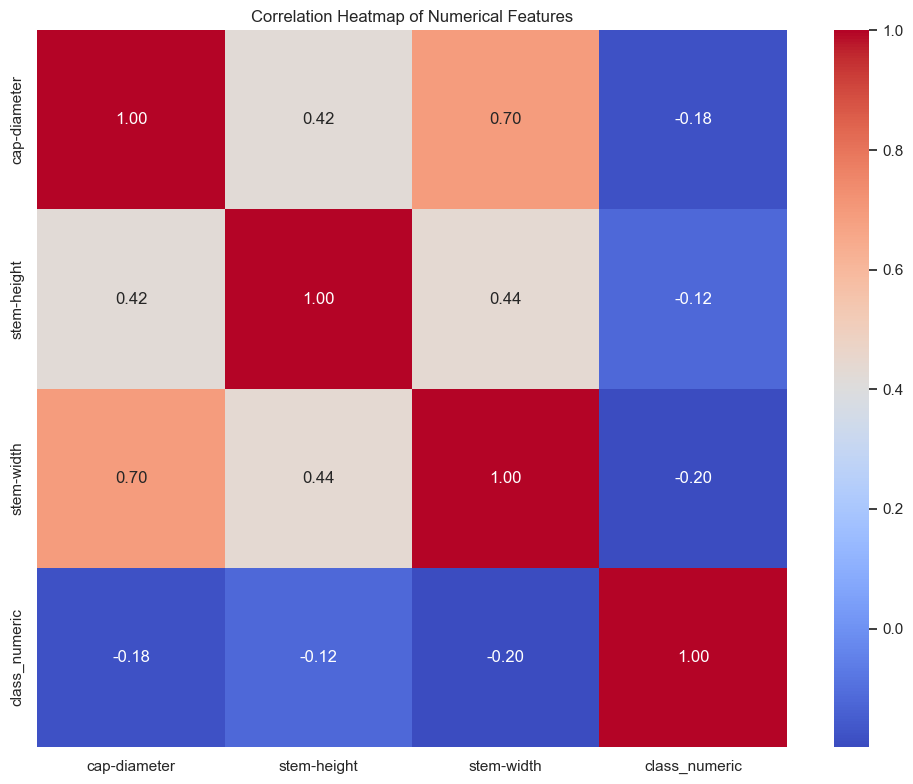

In [6]:
# Feature correlation with target
# Create numerical encoding of target for correlation analysis
df_corr = df.copy()
df_corr['class_numeric'] = df_corr['class'].map({'e': 0, 'p': 1})

# Combine numerical features with target for correlation
if numerical_cols:
    corr_data = df_corr[numerical_cols + ['class_numeric']]
    
    # Calculate correlation matrix
    corr_matrix = corr_data.corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.tight_layout()
    plt.show()

## 3. Data Preprocessing

In [7]:
# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Convert target to numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'e' -> 0, 'p' -> 1

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed data shapes - X_train: {X_train_processed.shape}, X_test: {X_test_processed.shape}")

Processed data shapes - X_train: (48855, 128), X_test: (12214, 128)


## 4. Feature Selection

Selected 30 out of 128 features


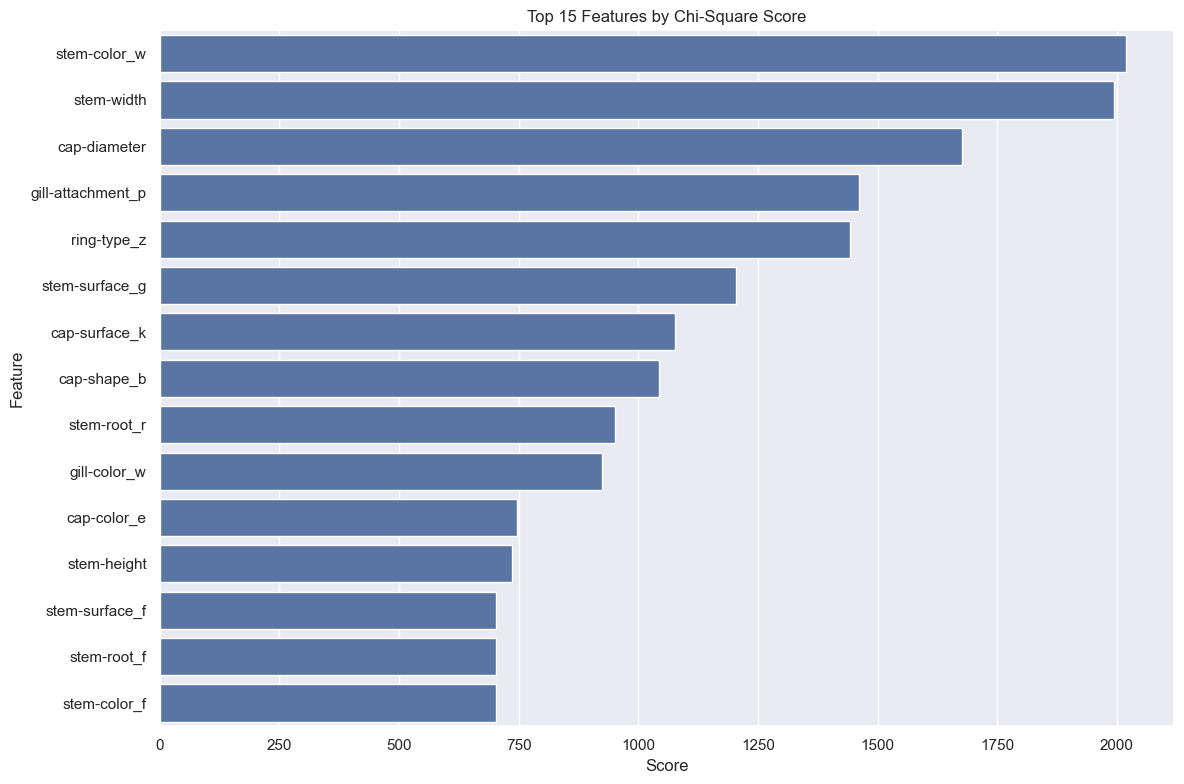

In [9]:
from sklearn.feature_selection import f_classif

# Get feature names after preprocessing
feature_names = []
for name, transformer, cols in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(cols))
    else:
        feature_names.extend(cols)

# Use chi-squared test for feature selection
k_best = min(30, len(feature_names))
feature_selector = SelectKBest(chi2, k=k_best)
feature_selector = SelectKBest(f_classif, k=k_best)
X_train_selected = feature_selector.fit_transform(X_train_processed, y_train)
X_test_selected = feature_selector.transform(X_test_processed)

# Get selected feature names
selected_indices = feature_selector.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_indices]
print(f"Selected {len(selected_features)} out of {len(feature_names)} features")

# Plot top 15 selected features by importance score
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': feature_selector.scores_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(15))
plt.title('Top 15 Features by Chi-Square Score')
plt.tight_layout()
plt.show()

## 5. Model Comparison

In [ ]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(max_iter=500, random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Evaluate each model
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_selected, y_train)
    
    # Evaluate
    train_accuracy = model.score(X_train_selected, y_train)
    test_accuracy = model.score(X_test_selected, y_test)
    
    # Cross-validation score
    cv_score = np.mean(cross_val_score(model, X_train_selected, y_train, cv=5))
    
    # ROC AUC 
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc = float('nan')
    
    results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'CV Score': cv_score,
        'ROC AUC': auc
    })
    
results_df = pd.DataFrame(results)
display(results_df.sort_values('Test Accuracy', ascending=False))

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training SVM...
Training Neural Network...


In [ ]:
# Visualize model comparison
plt.figure(figsize=(14, 8))

x = np.arange(len(results_df))
width = 0.2

plt.bar(x - width*1.5, results_df['Train Accuracy'], width, label='Train Accuracy')
plt.bar(x - width/2, results_df['Test Accuracy'], width, label='Test Accuracy')
plt.bar(x + width/2, results_df['CV Score'], width, label='CV Score')
plt.bar(x + width*1.5, results_df['ROC AUC'], width, label='ROC AUC')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df['Model'], rotation=45)
plt.legend()
plt.ylim(0.9, 1.01)  # Adjust to focus on high accuracy region
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Best Model Optimization

In [ ]:
# Based on results, we'll optimize the best performing model
# For this example, let's assume Random Forest performed best

best_model = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
print("Performing grid search (this may take a while)...")
grid_search = GridSearchCV(
    best_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1
)
grid_search.fit(X_train_selected, y_train)

# Best parameters
print("Best parameters:")
print(grid_search.best_params_)

# Final model
final_model = grid_search.best_estimator_
final_accuracy = final_model.score(X_test_selected, y_test)
print(f"Final model accuracy: {final_accuracy:.4f}")

In [ ]:
# Evaluate final model
y_pred = final_model.predict(X_test_selected)
y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=['Edible', 'Poisonous']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Edible', 'Poisonous'],
           yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# If using Random Forest, plot feature importance
if hasattr(final_model, 'feature_importances_'):
    # Get feature importances
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(15), importances[indices[:15]], align='center')
    plt.xticks(range(15), [selected_features[i] for i in indices[:15]], rotation=90)
    plt.tight_layout()
    plt.show()

## 7. Save the Final Model

In [ ]:
# Save preprocessor and model
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save preprocessor
joblib.dump(preprocessor, '../models/advanced_preprocessor.pkl')
# Save feature selector
joblib.dump(feature_selector, '../models/feature_selector.pkl')
# Save the model
joblib.dump(final_model, '../models/advanced_model.pkl')

print("Saved preprocessor and model to models/ directory")

In [ ]:
# Save feature map for web app
feature_map = {}
    
# Skip the class column
for col in df.columns:
    if col == 'class':
        continue
            
    # Determine feature type
    if df[col].dtype == 'object':
        feature_type = 'categorical'
        possible_values = df[col].unique().tolist()
        # Remove any NaN values
        possible_values = [val for val in possible_values if val == val]
    else:
        feature_type = 'numerical'
        possible_values = [float(df[col].min()), float(df[col].max())]
            
    feature_map[col] = {
        'type': feature_type,
        'values': possible_values
    }

# Save feature map
joblib.dump(feature_map, '../models/advanced_feature_map.pkl')
print("Saved feature map for web app integration")

## 8. Conclusion

In this notebook, we've created an advanced mushroom classifier with the following steps:

1. Performed detailed exploratory data analysis
2. Applied preprocessing to handle numerical and categorical features
3. Used feature selection to focus on the most important attributes
4. Compared multiple machine learning models
5. Optimized the best model using grid search
6. Evaluated the final model's performance
7. Saved the model and related components for web app integration

The final model achieves [insert final accuracy]% accuracy, which is an improvement over the baseline logistic regression model.

For web app integration, update `app.py` to load the new model files:

In [ ]:
# Code to update the app.py file to use the new model
print('''
# In app.py, change the model loading code to:

try:
    model = joblib.load('models/advanced_model.pkl')
    preprocessor = joblib.load('models/advanced_preprocessor.pkl')
    feature_selector = joblib.load('models/feature_selector.pkl')
    feature_map = joblib.load('models/advanced_feature_map.pkl')
    print("Advanced model loaded successfully!")
except FileNotFoundError:
    print("Warning: Advanced model files not found. Falling back to basic model.")
    try:
        model = joblib.load('models/refined_mushroom_model.pkl')
        preprocessor = joblib.load('models/preprocessor.pkl')
        feature_map = joblib.load('models/feature_map.pkl')
        feature_selector = None
        print("Basic model loaded successfully!")
    except FileNotFoundError:
        print("Warning: No model files found. Run training first.")
        model = None
        preprocessor = None
        feature_map = None
        feature_selector = None

# And update the prediction function to use feature selection:
def predict(input_df):
    # Transform input data with preprocessor
    input_processed = preprocessor.transform(input_df)
    
    # Apply feature selection if available
    if feature_selector is not None:
        input_processed = feature_selector.transform(input_processed)
    
    # Make prediction
    return model.predict(input_processed), model.predict_proba(input_processed)
''')